# Preprocess Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("resources/stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int64  
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int64  
 5   work_type          5110 non-null   int64  
 6   Residence_type     5110 non-null   int64  
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   int32  
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int32(1), int64(7)
memory usage: 419.3 KB


# Drop 'id' column

In [4]:
df = df.drop(['id'], axis=1)

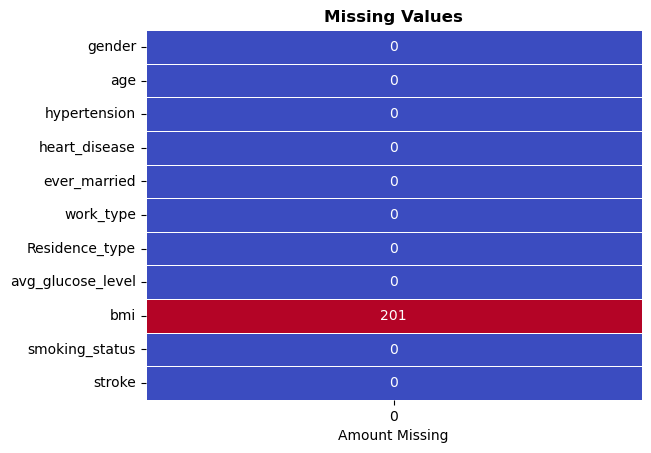

In [5]:
plt.title('Missing Values',fontweight='bold')
ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap='coolwarm', linewidths=0.5,cbar=False)
ax.set_xlabel('Amount Missing')
plt.show()

### Fill missing values

In [6]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

Text(0.5, 1.0, 'Stroke')

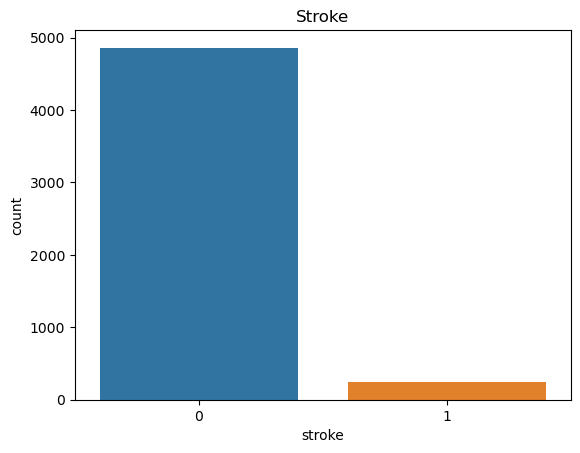

In [7]:
sns.countplot(data=df, x="stroke")
plt.title('Stroke')

# Look at the Data

In [8]:
round (df.describe(exclude = 'object'), 2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.0,5110.00,5110.00,5110.00,5110.00
mean,43.23,0.1,0.05,106.15,28.89,0.05
std,22.61,0.3,0.23,45.28,7.70,0.22
min,0.08,0.0,0.00,55.12,10.30,0.00
25%,25.00,0.0,0.00,77.24,23.80,0.00
50%,45.00,0.0,0.00,91.88,28.40,0.00
75%,61.00,0.0,0.00,114.09,32.80,0.00
max,82.00,1.0,1.00,271.74,97.60,1.00


In [9]:
round (df.describe(exclude = ['float', 'int64']),2)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


# Numeric Variable Distribution

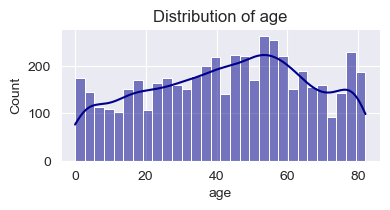

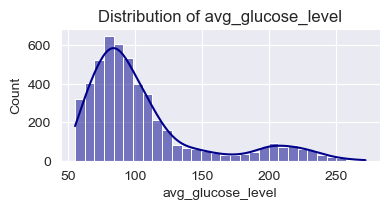

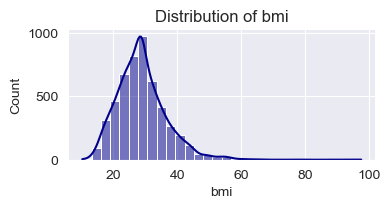

In [43]:
sns.set_style('darkgrid')


for col in df[['age','avg_glucose_level', 'bmi' ]].columns:
    sns.displot(df[col], bins=30, kde=True, color='darkblue', height=2, aspect=2).set(xlabel=col,title=f'Distribution of {col}')

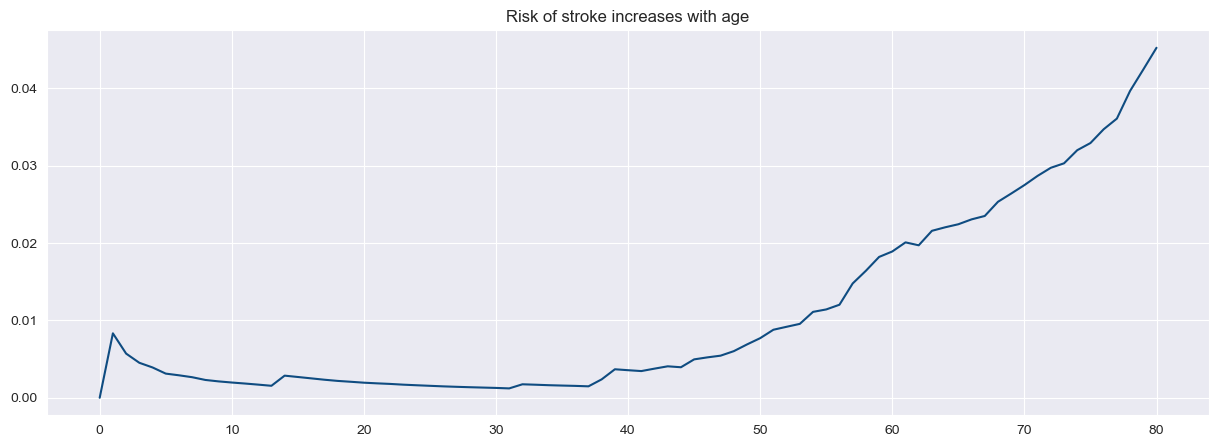

In [65]:
rate = []
ages = df['age'].astype(int)
for i in range(ages.min() + 1, ages.max()):
    rate.append((df[df['age'] < i]['stroke'].sum() / len(df[df['age'] < i]['stroke'])))
    
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(data=rate,color='#0f4c81', ax = ax).set(title='Risk of stroke increase with age')
plt.show()

# Model preparation

In [12]:
from sklearn.preprocessing import LabelEncoder

df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1})
df['ever_married'] = df['ever_married'].replace({'No':0,'Yes':1})
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1})
df['work_type'] = df['work_type'].replace({'Never_worked':-2,
                                           'children':-1, 
                                           'Private':0,
                                           'Self-employed':1,
                                           'Govt_job':2})

df['smoking_status'] = LabelEncoder().fit_transform(df['smoking_status'])

# Correlations 

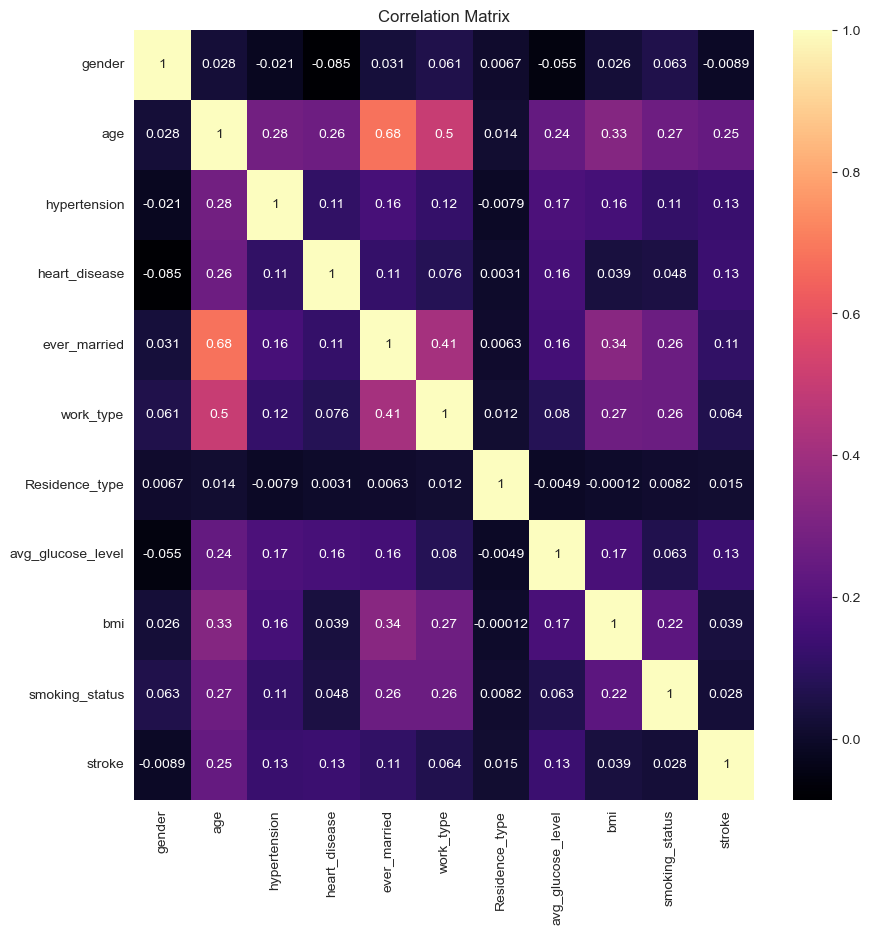

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap='magma', ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

## Split dataset

In [14]:
from sklearn.model_selection import train_test_split

X = df.drop(['stroke'], axis=1)
y = df['stroke']

## Balance dataset

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
oversampler = SMOTE(sampling_strategy = 1)

X, y = oversampler.fit_resample(X,y)

X_train_res, X_test, y_train_res, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<Axes: xlabel='stroke', ylabel='count'>

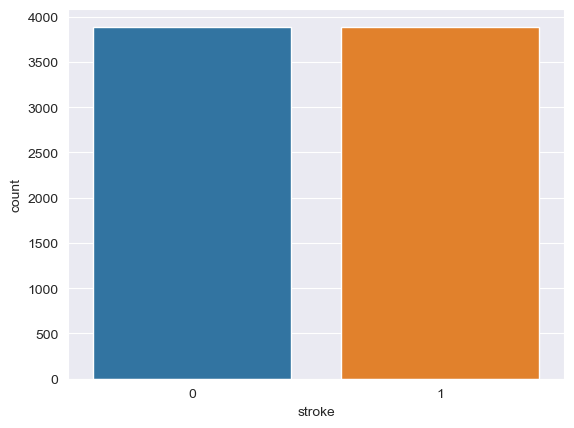

In [17]:
sns.countplot(x=y_train_res)

## Building Models

### RandomForest

In [18]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix



rf_pipeline = Pipeline(steps = [
                                ('KNN',KNeighborsClassifier())])


# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# rf_cv = cross_val_score(rf_pipeline,
#                         X_train_res,
#                         y_train_res,
#                         cv=cv,
#                         scoring='f1')

In [19]:
rf_pipeline.fit(X_train_res, y_train_res)
y_pred = rf_pipeline.predict(X_test)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.89       973
           1       0.85      0.98      0.91       972

    accuracy                           0.90      1945
   macro avg       0.91      0.90      0.90      1945
weighted avg       0.91      0.90      0.90      1945



In [21]:
rf_pipeline.score(X_test, y_test)

0.9023136246786633

<Axes: >

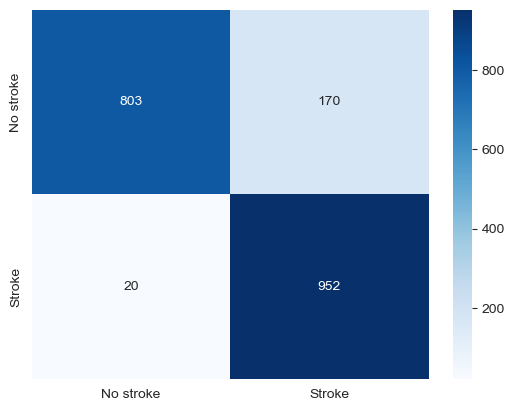

In [22]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['No stroke', 'Stroke'], yticklabels=['No stroke', 'Stroke'])

# Building neural network

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()

# X_train_res = scaler.fit_transform(X_train_res)
# X_test = scaler.fit_transform(X_test)

In [25]:
from keras.models import Sequential
from keras.layers import Dense

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import load_model

from sklearn.metrics import f1_score
import numpy as np

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [26]:
def select_model(layers, activation):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=X_train_res.shape[1], activation=activation))
    for i, node in enumerate(layers[1:]):
        model.add(Dense(node, activation=activation))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [27]:
model = KerasClassifier(select_model, verbose=1)

In [28]:
# layers = [[10], [30, 15], [30, 15, 5], [45, 30, 15, 5]]
# activations = ['tanh','relu']

# grid = GridSearchCV(estimator = model, param_grid = dict(layers = layers,
#                                                      activation = activations, 
#                                                     batch_size = [64],
#                                                     epochs=[30]))

# grid_res = grid.fit(X_train_res, y_train_res)

In [29]:
# [grid_res.best_score_, grid_res.best_params_]

In [30]:
# model = select_model([45, 30, 15, 5], 'tanh')

In [31]:
# model.fit(X_train_res, y_train_res, batch_size=64, epochs=300, validation_data=(X_test, y_test), verbose=2)

In [32]:
# model.save('test_model.md5')

In [35]:
model = load_model('my_model.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

61/61 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       973
           1       0.87      0.92      0.89       972

    accuracy                           0.89      1945
   macro avg       0.89      0.89      0.89      1945
weighted avg       0.89      0.89      0.89      1945



<Axes: >

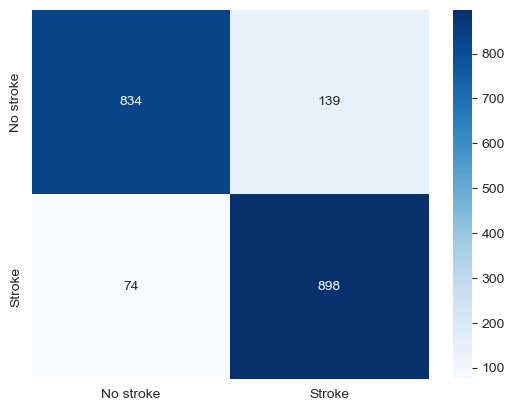

In [36]:
y_pred = model.predict(X_test)

y_pred = y_pred > 0.5

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['No stroke', 'Stroke'], yticklabels=['No stroke', 'Stroke'])

## Classifiers

1. KNN
2. SVM
3. DecissionTree
4. XGB
5. CatBoost
6. AdaBoost
